In [ ]:
!pip install https://github.com/odlgroup/odl/archive/master.zip
!pip install https://github.com/adler-j/adler/archive/master.zip

In [1]:
"""Learned primal-dual method."""

import os
import adler
adler.util.gpu.setup_one_gpu()

from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

np.random.seed(0)
name = 'learned_primal_dual_2d_notebook'

sess = tf.InteractiveSession()

# Create ODL data structures
size = 128
space = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=30)
operator = odl.tomo.RayTransform(space, geometry)

# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint,
                                                                  'RayTransformAdjoint')

# User selected paramters
n_data = 5
n_iter = 10
n_primal = 5
n_dual = 5

def generate_data(validation=False):
    """Generate a set of random data."""
    n_generate = 1 if validation else n_data

    y_arr = np.empty((n_generate, operator.range.shape[0], operator.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom = random_phantom(space)
        data = operator(phantom)
        noisy_data = data + odl.phantom.white_noise(operator.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr


with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator.range.shape[0], operator.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')


def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

primal_values = []
dual_values = []

with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            update = prelu(apply_conv(update), name='prelu_1')
            update = prelu(apply_conv(update), name='prelu_2')
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = prelu(apply_conv(update), name='prelu_1')
            update = prelu(apply_conv(update), name='prelu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update
            
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]


with tf.name_scope('loss'):
    residual = x_result - x_true
    squared_error = residual ** 2
    loss = tf.reduce_mean(squared_error)


with tf.name_scope('optimizer'):
    # Learning rate
    global_step = tf.Variable(0, trainable=False)
    maximum_steps = 5001
    starter_learning_rate = 1e-3
    learning_rate = cosine_decay(starter_learning_rate,
                                 global_step,
                                 maximum_steps,
                                 name='learning_rate')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        opt_func = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta2=0.99)

        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), 1)
        optimizer = opt_func.apply_gradients(zip(grads, tvars),
                                             global_step=global_step)


# Summaries
# tensorboard --logdir=...

with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('psnr', -10 * tf.log(loss) / tf.log(10.0))

    tf.summary.image('x_result', x_result)
    tf.summary.image('x_true', x_true)
    tf.summary.image('squared_error', squared_error)
    tf.summary.image('residual', residual)

    merged_summary = tf.summary.merge_all()
    
    tb_dir = adler.tensorflow.util.default_tensorboard_dir(name)
    print(f"TensorBoard directory: {tb_dir}")
    print(f"Type: {type(tb_dir)}")
    
    test_summary_writer = tf.summary.FileWriter(tb_dir + '/test',
                                                sess.graph)
    train_summary_writer = tf.summary.FileWriter(tb_dir + '/train')

# Initialize all TF variables
sess.run(tf.global_variables_initializer())

# Add op to save and restore
saver = tf.train.Saver()

# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data(validation=True)

if 0:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(name))

# Train the network
for i in range(0, maximum_steps):
    if i%10 == 0:
        y_arr, x_true_arr = generate_data()

    _, merged_summary_result_train, global_step_result = sess.run([optimizer, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr,
                                         y_rt: y_arr,
                                         is_training: True})

    if i>0 and i%10 == 0:
        loss_result, merged_summary_result, global_step_result = sess.run([loss, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr_validate,
                                         y_rt: y_arr_validate,
                                         is_training: False})

        train_summary_writer.add_summary(merged_summary_result_train, global_step_result)
        test_summary_writer.add_summary(merged_summary_result, global_step_result)

        print('iter={}, loss={}'.format(global_step_result, loss_result))

    if i>0 and i%1000 == 0:
        saver.save(sess,
                   adler.tensorflow.util.default_checkpoint_path(name))

Picking GPU(s) 0




Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend 

Training complete. Starting evaluation...
Running model evaluation...
SSIM: 0.9250
PSNR: 30.14 dB
Saving visualizations...
Iteration 0: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


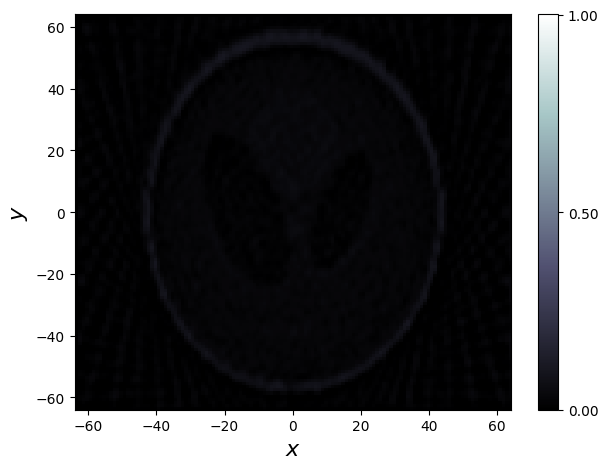

<Figure size 640x480 with 0 Axes>

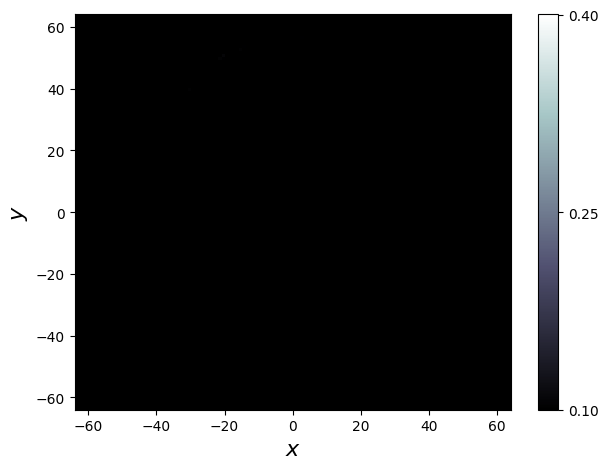

<Figure size 640x480 with 0 Axes>

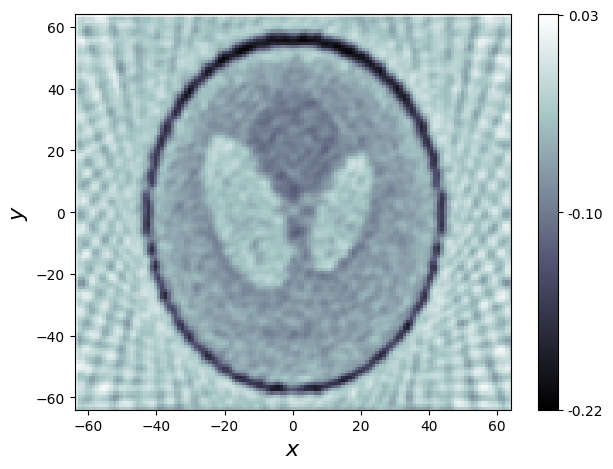

<Figure size 640x480 with 0 Axes>

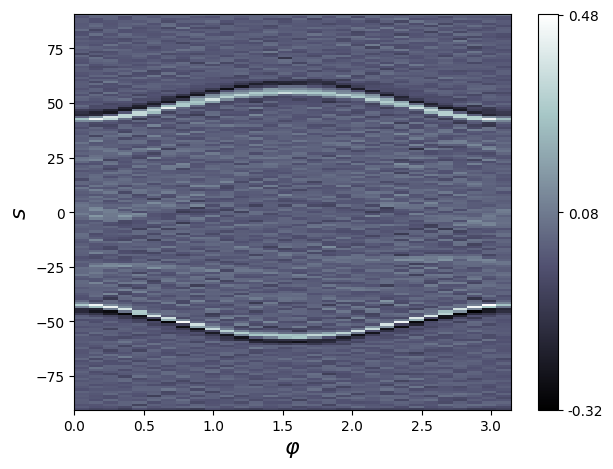

<Figure size 640x480 with 0 Axes>

Iteration 1: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


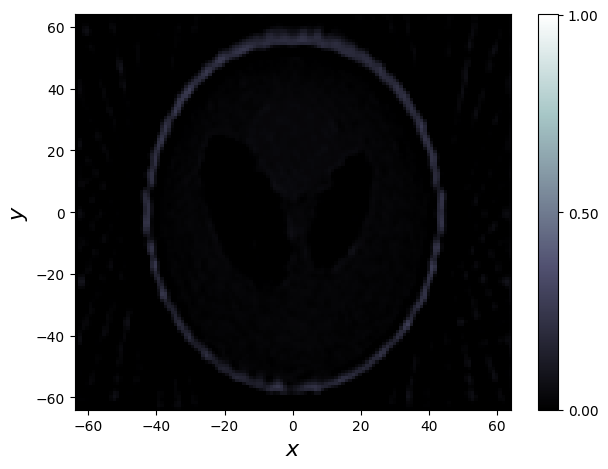

<Figure size 640x480 with 0 Axes>

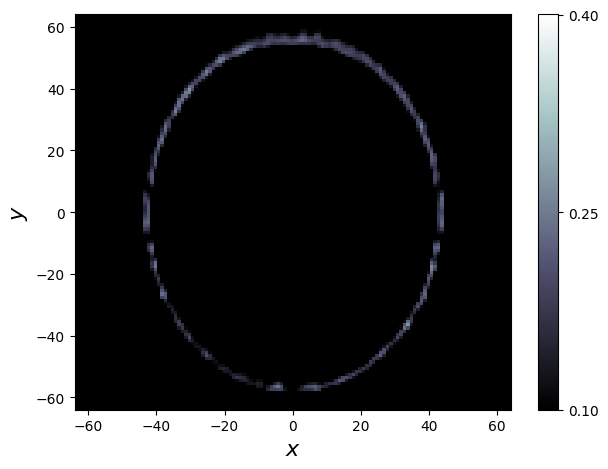

<Figure size 640x480 with 0 Axes>

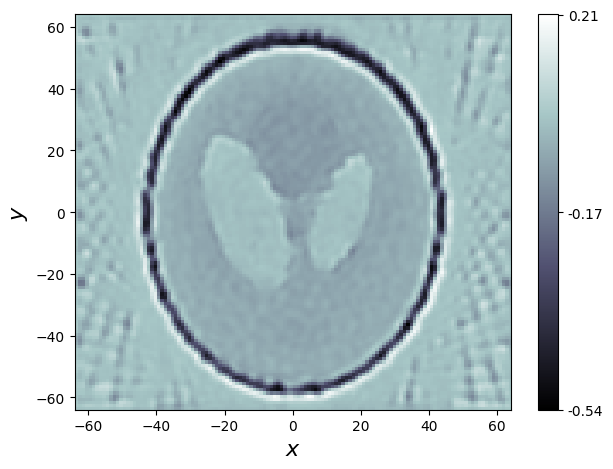

<Figure size 640x480 with 0 Axes>

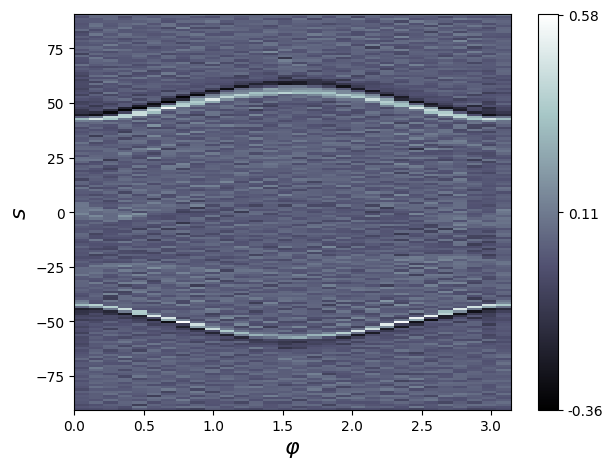

<Figure size 640x480 with 0 Axes>

Iteration 2: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


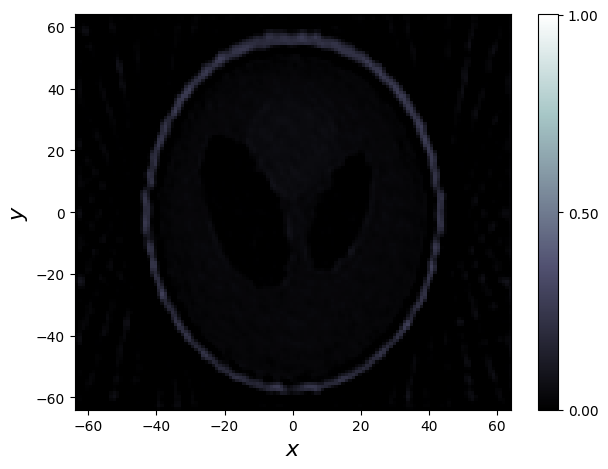

<Figure size 640x480 with 0 Axes>

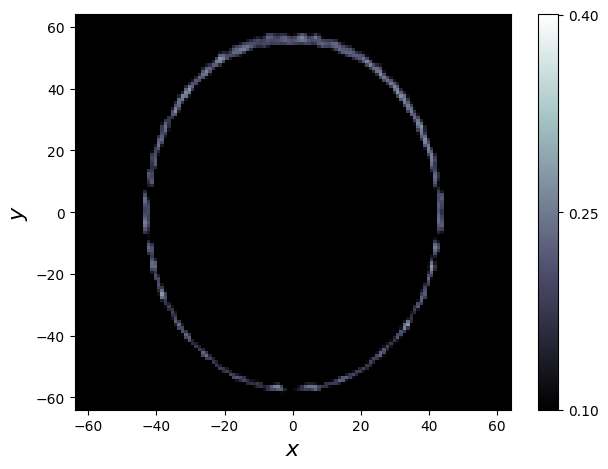

<Figure size 640x480 with 0 Axes>

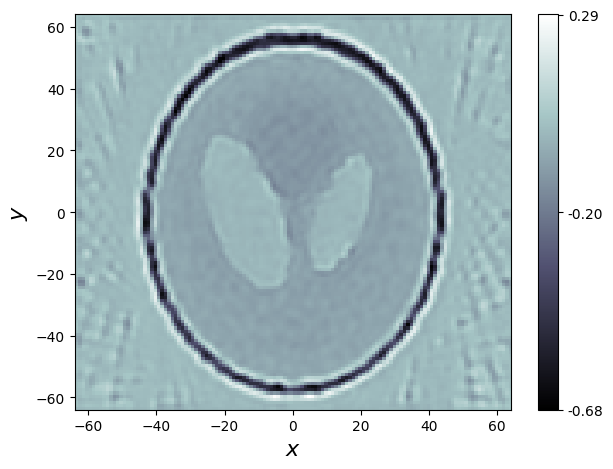

<Figure size 640x480 with 0 Axes>

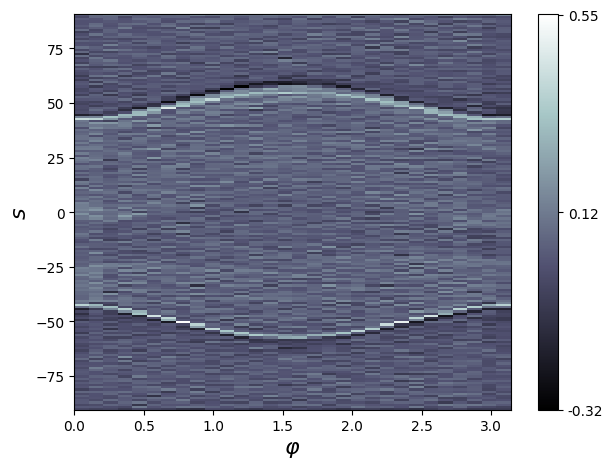

<Figure size 640x480 with 0 Axes>

Iteration 3: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


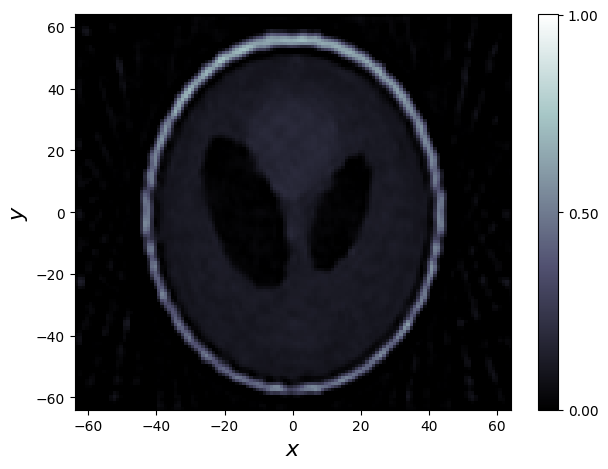

<Figure size 640x480 with 0 Axes>

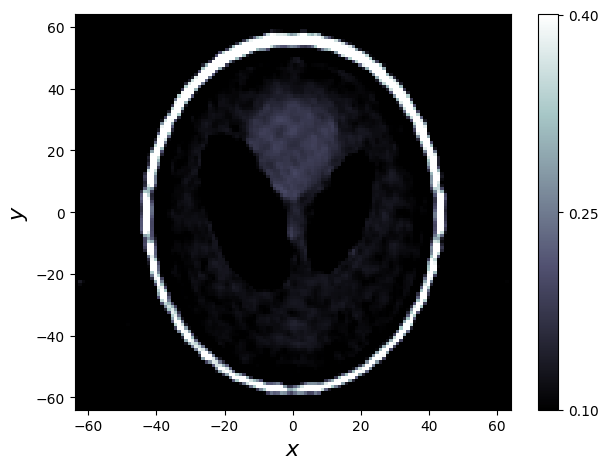

<Figure size 640x480 with 0 Axes>

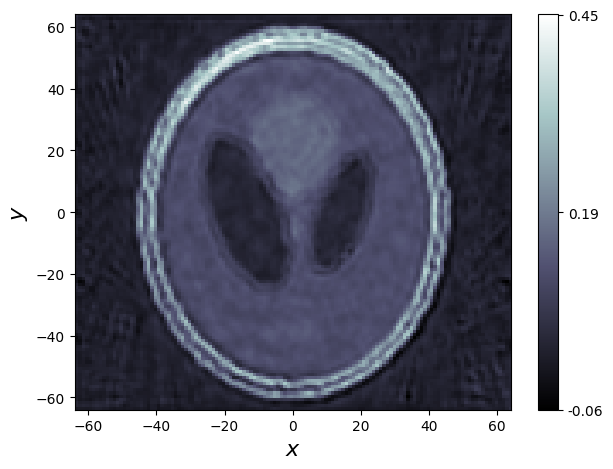

<Figure size 640x480 with 0 Axes>

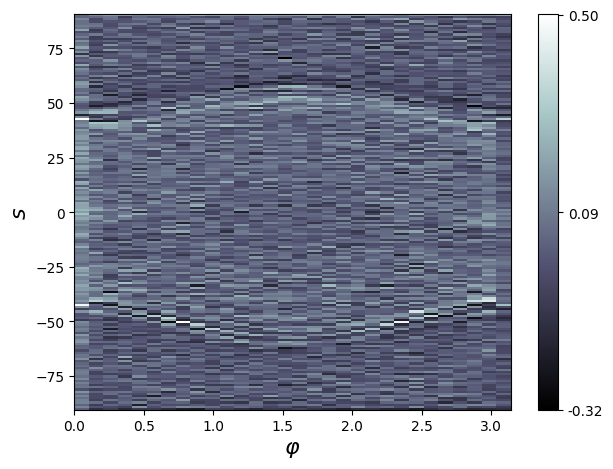

<Figure size 640x480 with 0 Axes>

Iteration 4: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


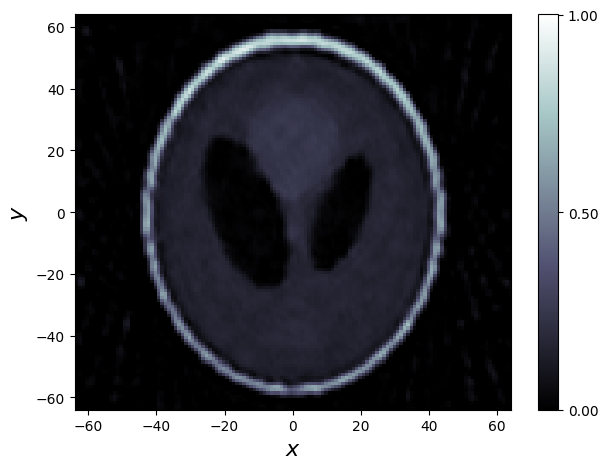

<Figure size 640x480 with 0 Axes>

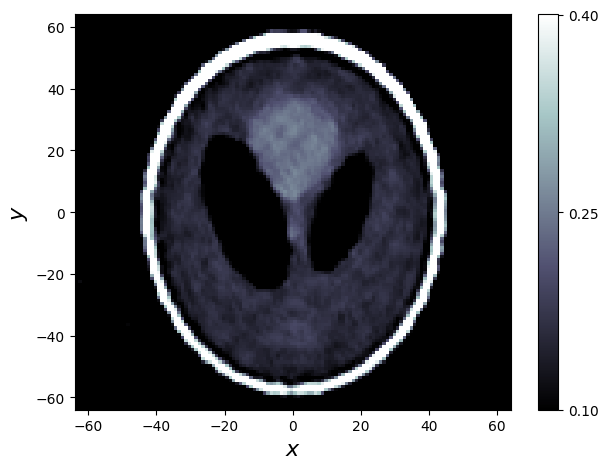

<Figure size 640x480 with 0 Axes>

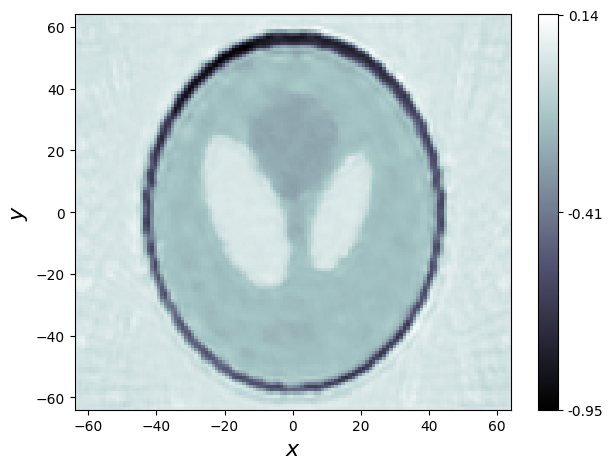

<Figure size 640x480 with 0 Axes>

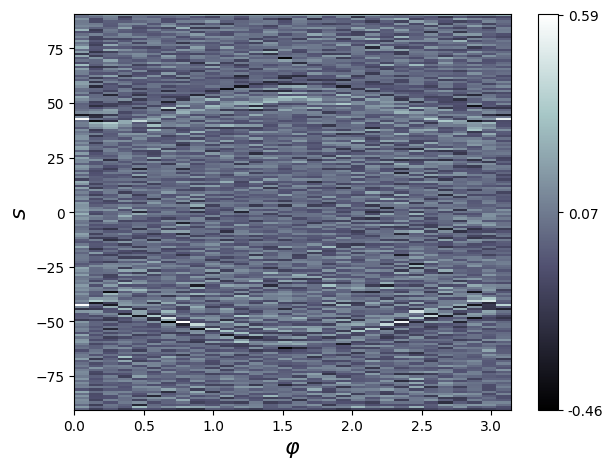

<Figure size 640x480 with 0 Axes>

Iteration 5: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


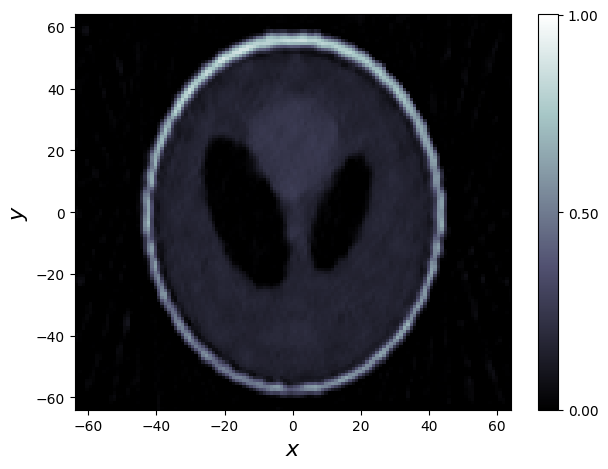

<Figure size 640x480 with 0 Axes>

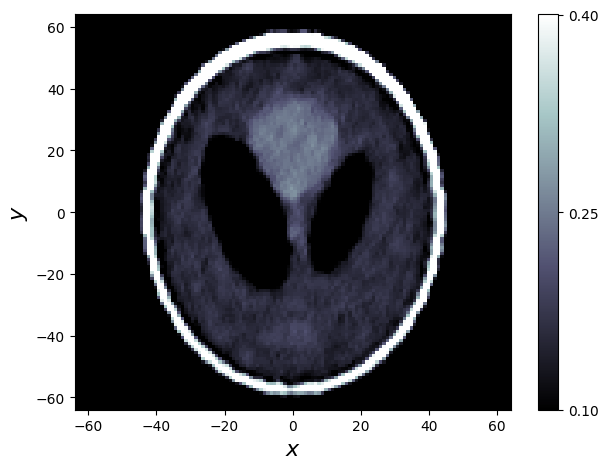

<Figure size 640x480 with 0 Axes>

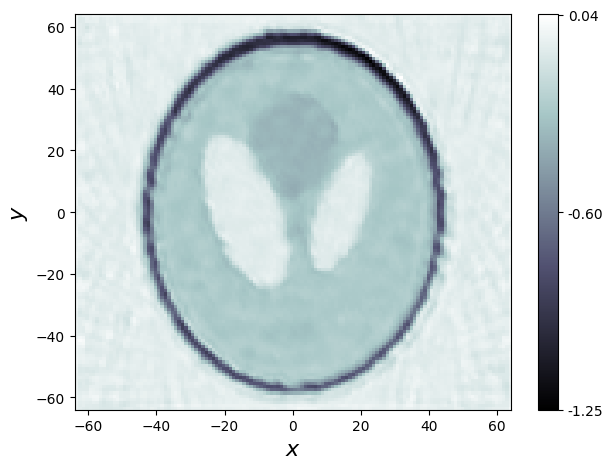

<Figure size 640x480 with 0 Axes>

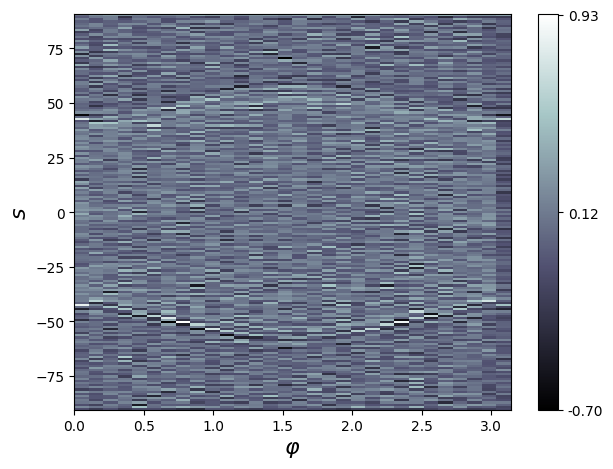

<Figure size 640x480 with 0 Axes>

Iteration 6: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


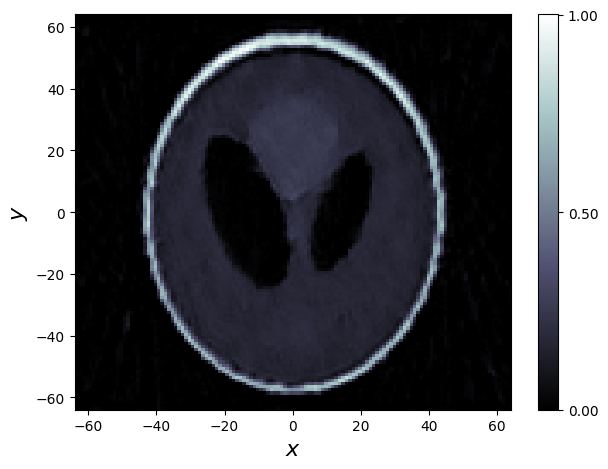

<Figure size 640x480 with 0 Axes>

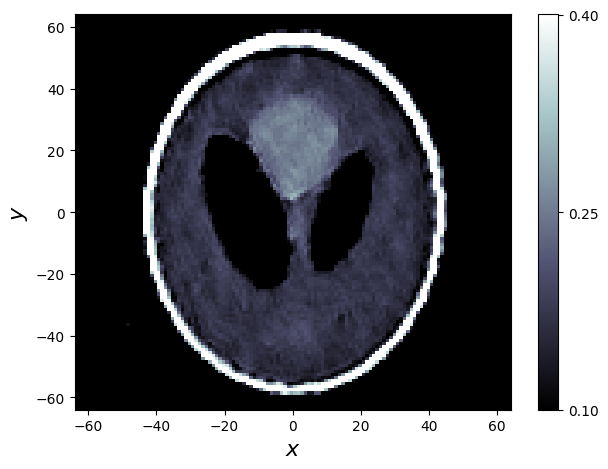

<Figure size 640x480 with 0 Axes>

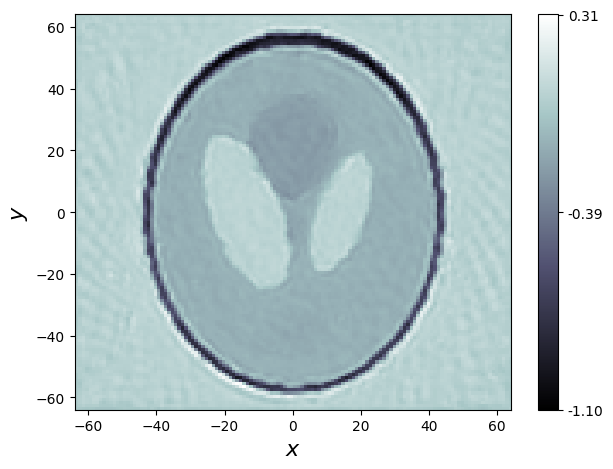

<Figure size 640x480 with 0 Axes>

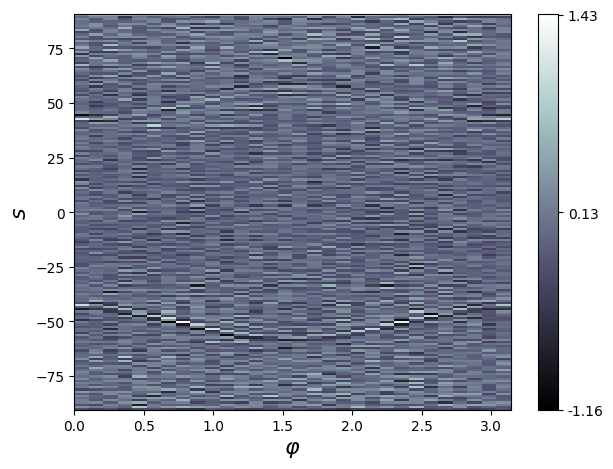

<Figure size 640x480 with 0 Axes>

Iteration 7: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


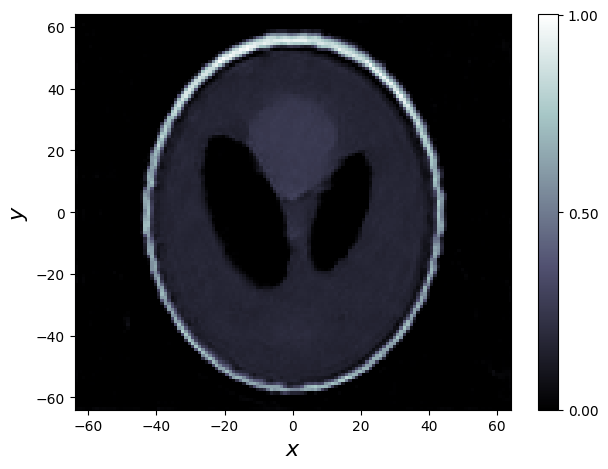

<Figure size 640x480 with 0 Axes>

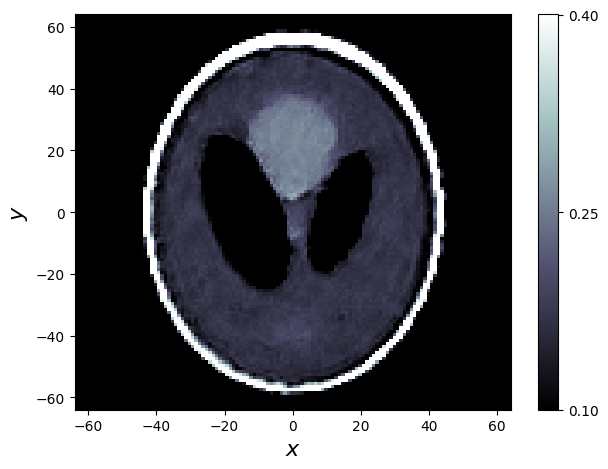

<Figure size 640x480 with 0 Axes>

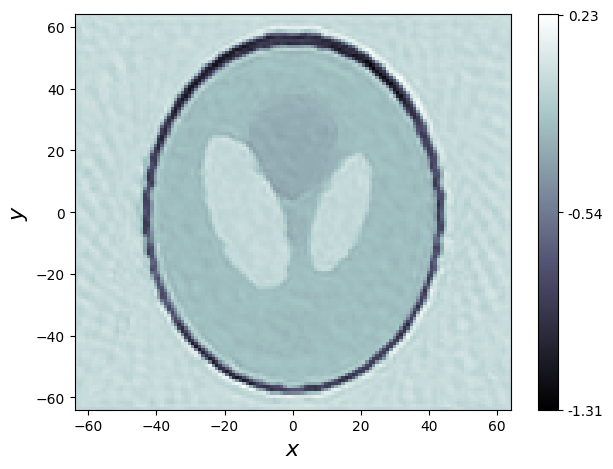

<Figure size 640x480 with 0 Axes>

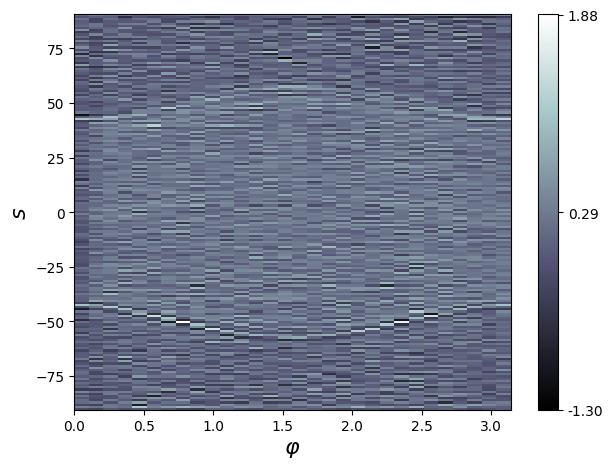

<Figure size 640x480 with 0 Axes>

Iteration 8: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


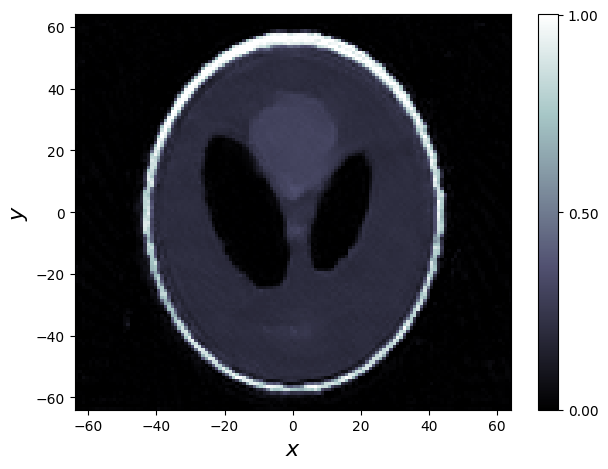

<Figure size 640x480 with 0 Axes>

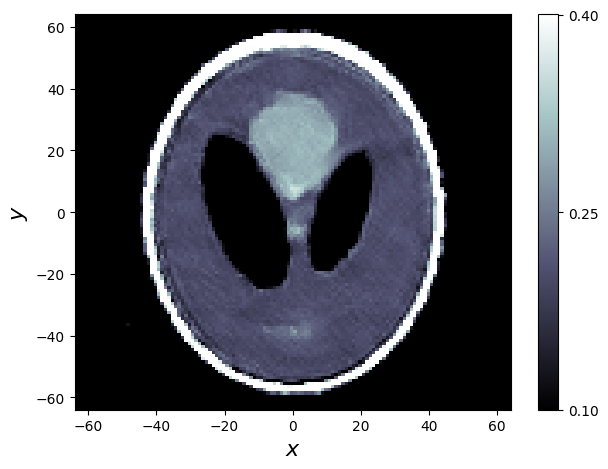

<Figure size 640x480 with 0 Axes>

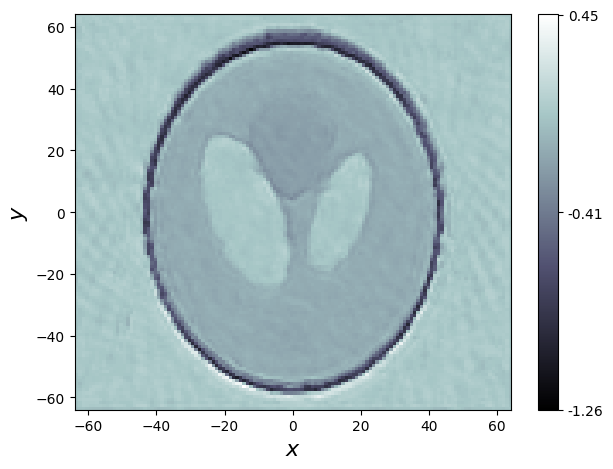

<Figure size 640x480 with 0 Axes>

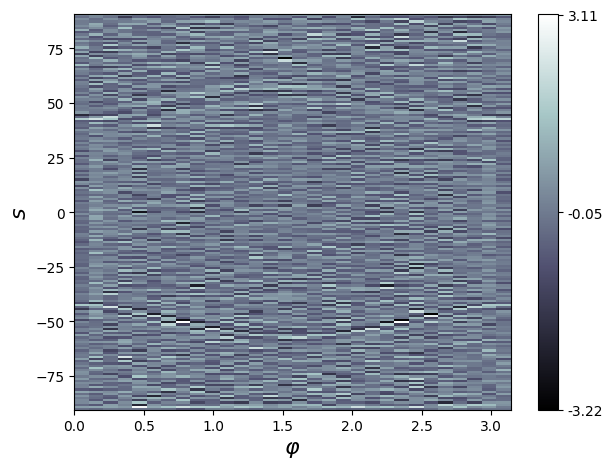

<Figure size 640x480 with 0 Axes>

Iteration 9: Primal shape = (1, 128, 128, 5), Dual shape = (1, 30, 183, 5)


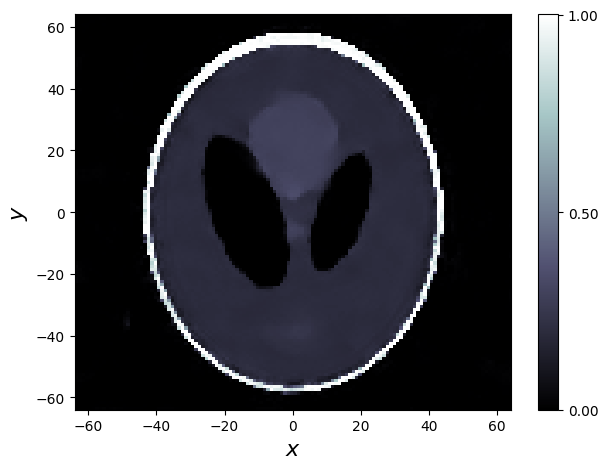

<Figure size 640x480 with 0 Axes>

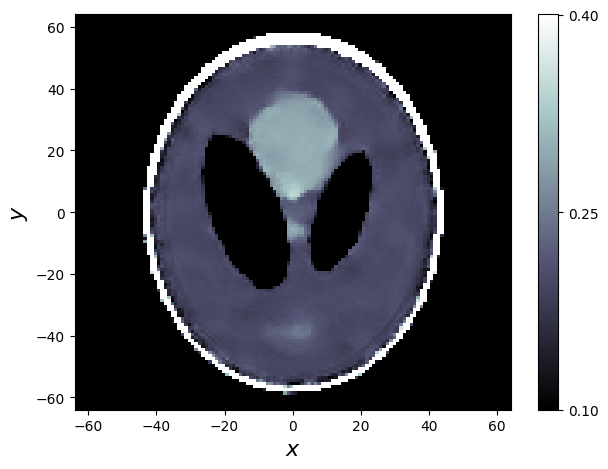

<Figure size 640x480 with 0 Axes>

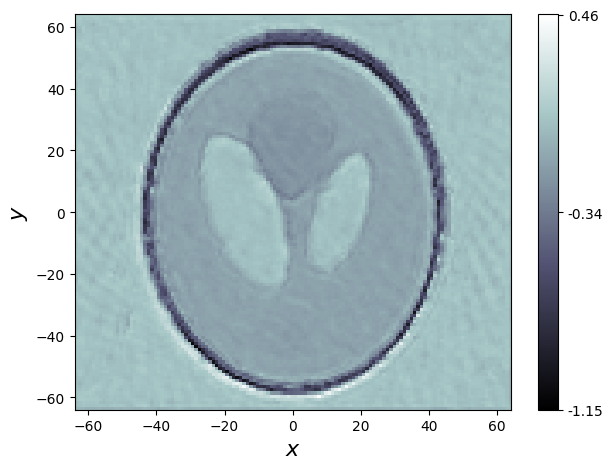

<Figure size 640x480 with 0 Axes>

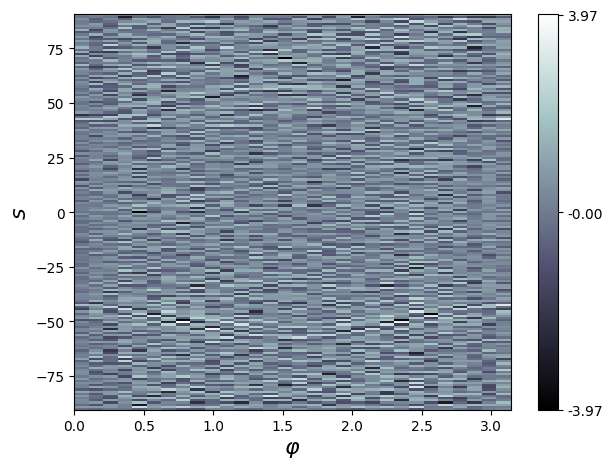

<Figure size 640x480 with 0 Axes>

Evaluation complete!

Summary:
Final SSIM: 0.9250
Final PSNR: 30.14 dB
Output saved to: learned_primal_dual_2d_notebook/


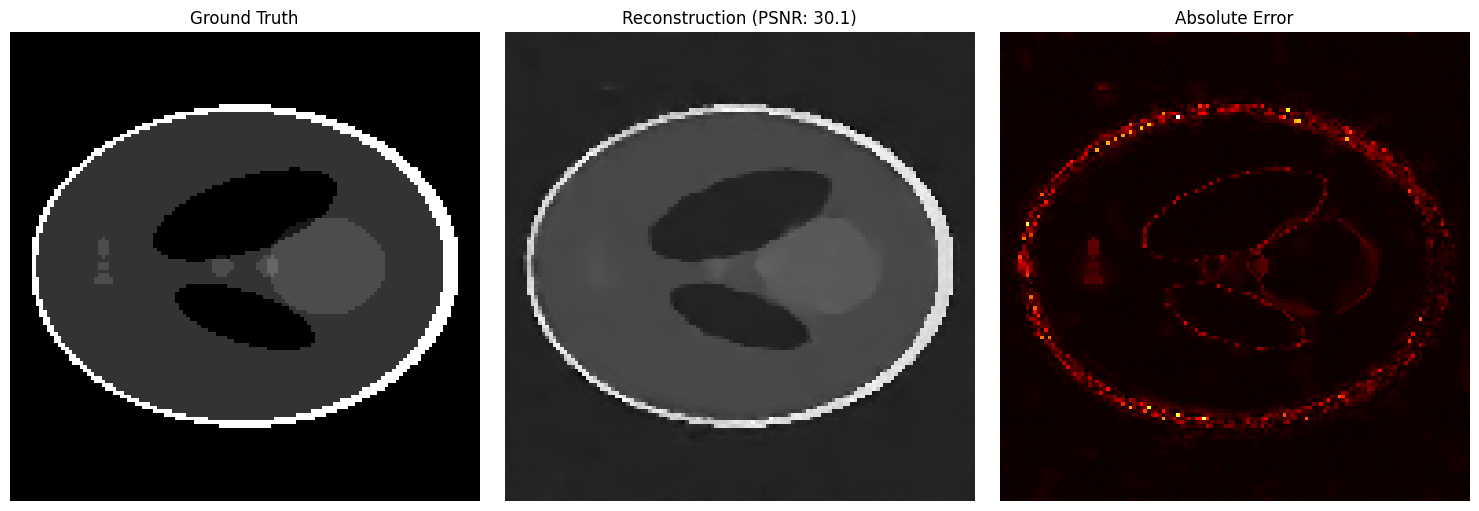

In [2]:
# Fixed evaluation code with proper error handling and compatibility

print("Training complete. Starting evaluation...")

# Generate validation data (if not already done)
if 'y_arr_validate' not in locals() or 'x_true_arr_validate' not in locals():
    print("Generating validation data...")
    y_arr_validate, x_true_arr_validate = generate_data(validation=True)

try:
    # Run evaluation
    print("Running model evaluation...")
    primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                          feed_dict={x_true: x_true_arr_validate,
                                     y_rt: y_arr_validate,
                                     is_training: False})
    
    # Import required libraries
    import matplotlib.pyplot as plt
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr
    
    # Calculate and print metrics
    final_result = primal_values_result[-1][0, ..., 0]
    ground_truth = x_true_arr_validate[0, ..., 0]
    
    ssim_value = ssim(final_result, ground_truth, data_range=1.0)
    psnr_value = psnr(final_result, ground_truth, data_range=1.0)
    
    print(f"SSIM: {ssim_value:.4f}")
    print(f"PSNR: {psnr_value:.2f} dB")
    
    # Create output directory
    import os
    path = name
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    
    # Save visualizations for each iteration
    print("Saving visualizations...")
    for i in range(n_iter):
        try:
            # Check if primal has enough channels before accessing channel 1
            primal_shape = primal_values_result[i].shape
            print(f"Iteration {i}: Primal shape = {primal_shape}, Dual shape = {dual_values_result[i].shape}")
            
            # Main reconstruction (channel 0)
            space.element(primal_values_result[i][0, ..., 0]).show(
                clim=[0, 1], 
                saveto=f'{path}/x_{i}.png'
            )
            
            # Windowed view
            space.element(primal_values_result[i][0, ..., 0]).show(
                clim=[0.1, 0.4], 
                saveto=f'{path}/x_windowed_{i}.png'
            )
            
            # Only show auxiliary channel if it exists (channel 1)
            if primal_shape[-1] > 1:
                space.element(-primal_values_result[i][0, ..., 1]).show(
                    saveto=f'{path}/x_eval_{i}.png'
                )
            else:
                print(f"Warning: Iteration {i} - Primal has only {primal_shape[-1]} channel(s), skipping auxiliary visualization")
            
            # Dual variable (channel 0)
            dual_shape = dual_values_result[i].shape
            if len(dual_shape) == 4:  # [batch, height, width, channels]
                operator.range.element(dual_values_result[i][0, ..., 0]).show(
                    saveto=f'{path}/y_{i}.png'
                )
            else:
                print(f"Warning: Unexpected dual shape at iteration {i}: {dual_shape}")
            
            plt.close('all')  # Close all matplotlib figures to free memory
            
        except Exception as e:
            print(f"Error processing iteration {i}: {str(e)}")
            continue
    
    print("Evaluation complete!")
    
    # Optional: Print summary statistics
    print(f"\nSummary:")
    print(f"Final SSIM: {ssim_value:.4f}")
    print(f"Final PSNR: {psnr_value:.2f} dB")
    print(f"Output saved to: {path}/")
    
except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    print("Make sure the model has been trained and the session is still active")

# Optional: Display final result comparison
try:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(x_true_arr_validate[0, ..., 0], cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    
    axes[1].imshow(primal_values_result[-1][0, ..., 0], cmap='gray')
    axes[1].set_title(f'Reconstruction (PSNR: {psnr_value:.1f})')
    axes[1].axis('off')
    
    axes[2].imshow(np.abs(primal_values_result[-1][0, ..., 0] - x_true_arr_validate[0, ..., 0]), cmap='hot')
    axes[2].set_title('Absolute Error')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{path}/comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
except Exception as e:
    print(f"Error creating comparison plot: {str(e)}")